In [71]:
import pandas as pd
import urllib.request
%matplotlib inline
import matplotlib.pyplot as plt
import re
from konlpy.tag import Okt
from tensorflow.keras.preprocessing.text import Tokenizer
import numpy as np
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split

from tensorflow.keras.optimizers import RMSprop, Adam
import tensorflow as tf
import csv 

In [72]:
data = pd.read_csv('datasets/naver_movie_all.csv')
data = data[['document', 'label', 'star']]
print(data.shape)
data.head()

(16465, 3)


,document,label,star
0,와우,1,10
1,아이들과 정말 재밌게봤어요~,1,10
2,"진부한 스토리가 예상되고 넷플릭스의 수많은 저질 작품들, 또 나오는 크리스 햄스워스...",1,10
3,팝콘 먹으러 영화관온거 같음....아.. 맞다.. 푹 자서 내용이 기억이 안나네?,0,1
4,훌륭합니다. 몰입하게 되는 영화,1,10


In [75]:
train_data, test_data = train_test_split(data, test_size=0.33, random_state=777)

In [76]:
print('훈련용 리뷰 개수 :',len(train_data)) # 훈련용 리뷰 개수 출력
print('테스트용 리뷰 개수 :',len(test_data)) # 테스트용 리뷰 개수 출력

훈련용 리뷰 개수 : 11031
테스트용 리뷰 개수 : 5434


In [77]:
train_data[:5] # 상위 5개 출력

,document,label,star
11288,"엔딩을 보여 ""뭐야 이게 끝이야?"" 라는 반응이 나왔지만 긴장감 하나만큼은 최고. ...",1,8
1019,진짜 영화 보는 내내 재미있었다.,1,10
7471,휴... 캐붕에 오유랑 설정이 어긋나는 부분들이 있어서 차라리 오유랑 선 긋고 맘이...,1,8
14784,솔직히 긴장도 전혀 안 됐다. 긴장도 스토리에서 오는 건데.,0,2
2690,트롤졸귀다재밋어용ost도좋음,1,10


In [78]:
print('테스트용 리뷰 개수 :',len(test_data)) # 테스트용 리뷰 개수 출력

테스트용 리뷰 개수 : 5434


In [79]:
test_data[:5]

,document,label,star
5233,핵노잼임 절대 보지마세요,0,1
11751,영화는 정말 개연성 없이 지루하고 맥락 없이 이어지는 데 이상하게 쫄깃하고 이상하게...,1,10
2758,연출과 그래픽이 볼만한 성인판 헬보이 재밋다.,1,8
5288,코로나 때문에 극장 개봉 못하고 네플릭스에 판매된건 제작진 입장에서는 최고의 한수 ...,0,3
8252,여행 갔다가 1일 뒤에 돌아와서 밤에 기대안하고 보러갔는데 진짜 잘만든거 같아요 영...,1,10


### Preprocessing

In [80]:
# 데이터 중복 확인
train_data['document'].nunique(), train_data['label'].nunique()

(7806, 2)

In [81]:
# document 열에서 중복인 내용이 있다면 중복 제거
train_data.drop_duplicates(subset=['document'], inplace=True) 

/Users/jshin/opt/anaconda3/envs/ml2/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [82]:
print('총 샘플의 수 :',len(train_data))

총 샘플의 수 : 7806


In [30]:
# train_data['label'].value_counts().plot(kind = 'bar')

In [83]:
# 긍정과 부정의 수를 확인한다 (label=0이면 부정, label=1이면 긍정으로 표시한다)

# train_data['label'].value_counts()
print(train_data.groupby('label').size().reset_index(name = 'count'))

   label  count
0      0   2380
1      1   5426


In [84]:
train_data['label'].value_counts()

1    5426
0    2380
Name: label, dtype: int64

In [85]:
# 결측치 확인하기 - 나중참고용
# print(train_data.isnull().sum())
train_data.loc[train_data.document.isnull()]
train_data = train_data.dropna(how = 'any') # Null 값이 존재하는 행 제거

print(train_data.isnull().values.any()) # Null 값이 존재하는지 확인
print(train_data.isnull().any()) # Null 값이 존재하는지 확인
# print(len(train_data))

False
document    False
label       False
star        False
dtype: bool


In [86]:
# 한글과 공백을 제외하고 모두 제거
train_data['document'] = train_data['document'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")

# 알파벳과 공백을 제외하고 모두 제거(나중에 영어텍스트만 남기고 싶을때 사용)
# train_data['document'] = train_data['document'].str.replace("[^a-zA-Z ]","")

In [35]:
# https://www.unicode.org/charts/PDF/U3130.pdf
# ㄱ ~ ㅎ: 3131 ~ 314E
# ㅏ ~ ㅣ: 314F ~ 3163
# https://www.unicode.org/charts/PDF/UAC00.pdf
# 가 ~ 힣

In [87]:
train_data[:5]

,document,label,star
11288,엔딩을 보여 뭐야 이게 끝이야 라는 반응이 나왔지만 긴장감 하나만큼은 최고 보는 내...,1,8
1019,진짜 영화 보는 내내 재미있었다,1,10
7471,휴 캐붕에 오유랑 설정이 어긋나는 부분들이 있어서 차라리 오유랑 선 긋고 맘이 편합...,1,8
14784,솔직히 긴장도 전혀 안 됐다 긴장도 스토리에서 오는 건데,0,2
2690,트롤졸귀다재밋어용도좋음,1,10


In [88]:
# 영어로만 작성된 리뷰도 삭제 됨
train_data['document'].replace('', np.nan, inplace=True)
print(train_data.isnull().sum())

document    0
label       0
star        0
dtype: int64


In [89]:
train_data.loc[train_data.document.isnull()][:5]

,document,label,star


In [90]:
train_data = train_data.dropna(how = 'any')
print(len(train_data))

7806


In [91]:
save_csv = train_data[:100]
save_csv.to_csv('tain_data.csv')

In [41]:
### test 데이터 전처리(tain과 동일)

In [92]:
test_data.drop_duplicates(subset = ['document'], inplace=True) # document 열에서 중복인 내용이 있다면 중복 제거
test_data['document'] = test_data['document'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","") # 정규 표현식 수행
test_data['document'].replace('', np.nan, inplace=True) # 공백은 Null 값으로 변경
test_data = test_data.dropna(how='any') # Null 값 제거
print('전처리 후 테스트용 샘플의 개수 :',len(test_data))

전처리 후 테스트용 샘플의 개수 : 4648


/Users/jshin/opt/anaconda3/envs/ml2/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/Users/jshin/opt/anaconda3/envs/ml2/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Users/jshin/opt/anaconda3/envs/ml2/lib/python3.7/site-packages/pandas/core/generic.py:6746: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/p

### Tokenization

In [93]:
# 불용어 제거, 한국어의 조사, 접속사 등 -> 지속적으로 검토하면서 추가해서 삭제
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']

In [94]:
# 토큰화를 위한 형태소 분석기는 KoNLPy의 Okt
okt = Okt()
# okt.morphs('2000년이후 최고의 서스펜스... 라고 했지만, 이걸 왜 봤을까', stem = True)

In [95]:
ko_file = pd.read_csv('ko.csv', index_col=0)
ko_file

""
아
휴
아이구
아이쿠
아이고
어
...
일곱
여덟
아홉


In [96]:
jdata = train_data

jdata

,document,label,star
11288,엔딩을 보여 뭐야 이게 끝이야 라는 반응이 나왔지만 긴장감 하나만큼은 최고 보는 내...,1,8
1019,진짜 영화 보는 내내 재미있었다,1,10
7471,휴 캐붕에 오유랑 설정이 어긋나는 부분들이 있어서 차라리 오유랑 선 긋고 맘이 편합...,1,8
14784,솔직히 긴장도 전혀 안 됐다 긴장도 스토리에서 오는 건데,0,2
2690,트롤졸귀다재밋어용도좋음,1,10
...,...,...,...
6798,마지막이어서 너무 아쉽지만 ㅜㅜ 그래도 내 대를 책임져준 영화였다 개인적으론 편이...,1,10
6541,최고다 아무도 모른다 그렇게 아버지가 된다 모두 대단한 작품들,1,10
11032,감독은 넷플릭스 가서 한 년이상 무료 청소해라 극장 개봉했음 그냥 개폭망작이다 인터...,0,2
4017,기대하고봤는데도 대만족,1,10


### 명사만 추출하기

In [97]:
# 불용어 제거
# 형태소 토큰화
X_train = []
for sentence in train_data['document']:
    temp_X = []
    temp_X = okt.morphs(sentence, stem=True) # 토큰화
    temp_X = [word for word in temp_X if not word in ko_file] # 불용어 제거
    X_train.append(temp_X)

In [98]:
X_train[10]

['사냥',
 '감',
 '이',
 '되다',
 '인간',
 '의',
 '심리',
 '를',
 '자다',
 '표현',
 '함',
 '연기',
 '와',
 '미장센',
 '이',
 '뛰어나다']

In [99]:
print(X_train[0])

['엔딩', '을', '보이다', '뭐', '야', '이', '게', '끝', '이야', '라는', '반응', '이', '나오다', '긴장감', '하나', '만큼은', '최고', '보다', '내내', '심장', '이', '빨리', '뛰다', '소위', '말다', '쫄린다', '는', '느낌', '이', '무척', '강하다', '그리고', '살다', '크다', '문제', '에', '맞닥뜨렸', '을', '때', '계속', '피하', '기만', '하다', '어느', '곳', '에서도', '빠지다', '나가다', '수', '없다', '나름', '의', '교훈', '도', '있다', '것', '같다', '전체', '적', '으로', '추천', '하다']


In [100]:
X_test = []
for sentence in test_data['document']:
    temp_X = []
    temp_X = okt.morphs(sentence, stem=True) # 토큰화
    temp_X = [word for word in temp_X if not word in ko_file] # 불용어 제거
    X_test.append(temp_X)

In [51]:
### 정수 인코딩

In [101]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)

In [102]:
print(tokenizer.word_index)

{'이': 1, '하다': 2, '영화': 3, '보다': 4, '에': 5, '의': 6, '가': 7, '을': 8, '들': 9, '도': 10, '는': 11, '은': 12, '를': 13, '있다': 14, '없다': 15, '좋다': 16, '이다': 17, '너무': 18, '스토리': 19, '한': 20, '같다': 21, '으로': 22, '되다': 23, '다': 24, '연기': 25, '에서': 26, '배우': 27, '아니다': 28, '만': 29, '로': 30, '재밌다': 31, '적': 32, '진짜': 33, '긴장감': 34, '과': 35, '것': 36, '생각': 37, '않다': 38, '평점': 39, '시간': 40, '그': 41, '안': 42, '나오다': 43, '만들다': 44, '점': 45, '연출': 46, '사람': 47, '못': 48, '나': 49, '정말': 50, '인': 51, '고': 52, '게': 53, '왜': 54, '내': 55, '더': 56, '까지': 57, '그냥': 58, '감독': 59, '하고': 60, '자다': 61, '수': 62, '보고': 63, '와': 64, '정도': 65, '들다': 66, '때': 67, '액션': 68, '가다': 69, '말': 70, '거': 71, '최고': 72, '싶다': 73, '모르다': 74, '이렇다': 75, '많다': 76, '볼': 77, '그렇다': 78, '주다': 79, '잘': 80, '하나': 81, '오다': 82, '좀': 83, '느낌': 84, '장면': 85, '저': 86, '요': 87, '뭐': 88, '개': 89, '재미있다': 90, '그리고': 91, '내용': 92, 'ㅋㅋ': 93, '알다': 94, '넷플릭스': 95, '사냥': 96, '아쉽다': 97, '이렇게': 98, '처음': 99, '중': 100, '네': 101, '성': 102, '끝': 103, '걸

In [103]:
threshold = 2 # 빈도수가 3회 미만은 제거
total_cnt = len(tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

In [104]:
print('단어 집합(vocabulary)의 크기 :',total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 12170
등장 빈도가 1번 이하인 희귀 단어의 수: 5658
단어 집합에서 희귀 단어의 비율: 46.49137222678718
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 3.104867475168743


In [105]:
vocab_size = total_cnt - rare_cnt + 1 # 전체 단어 개수 중 빈도수 2이하인 단어 개수는 제거. 0번 패딩 토큰을 고려하여 +1
print('단어 집합의 크기 :',vocab_size)

단어 집합의 크기 : 6513


In [106]:
import pickle
vocab_size = vocab_size

with open('./save/vocab_size.p', 'wb') as file:    # james.p 파일을 바이너리 쓰기 모드(wb)로 열기
    pickle.dump(vocab_size, file)

In [107]:
# 토크나이저는 텍스트 시퀀스를 숫자 시퀀스로 변환하는 정수 인코딩 과정에서 
# 이보다 큰 숫자가 부여된 단어들은 아예 계산하지 않음
tokenizer = Tokenizer(vocab_size) 
tokenizer.fit_on_texts(X_train)
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

In [108]:
print(X_train[:3])

[[451, 8, 368, 88, 274, 1, 53, 103, 693, 185, 2084, 1, 43, 34, 81, 1146, 72, 4, 186, 449, 1, 807, 1503, 221, 11, 84, 1, 2272, 758, 91, 190, 169, 456, 5, 8, 67, 249, 2860, 1696, 2, 452, 664, 595, 326, 521, 62, 15, 247, 6, 778, 10, 14, 36, 21, 552, 32, 22, 194, 2], [33, 3, 4, 186, 90], [975, 5, 4752, 200, 240, 1, 3837, 140, 9, 1, 14, 563, 4752, 200, 710, 2273, 665, 1, 952, 142, 142, 130, 75, 746, 710, 680, 2, 62, 15, 1593, 1697, 213, 46, 12, 33, 1697, 213, 46, 1, 196, 132, 563, 4753, 3263, 54, 191, 1926, 1225, 16, 35, 2861, 46, 145, 5, 45, 79, 69, 19, 11, 58, 4754, 746, 51, 104, 30, 37, 2]]


In [109]:
y_train = np.array(train_data['label'])
y_test = np.array(test_data['label'])

### 빈 샘플(Empty samples) 제거

In [110]:
drop_train = [index for index, sentence in enumerate(X_train) if len(sentence) < 1]
drop_test = [index for index, sentence in enumerate(X_test) if len(sentence) < 1]

In [111]:
# 빈 샘플들을 제거
X_train = np.delete(X_train, drop_train, axis=0)
y_train = np.delete(y_train, drop_train, axis=0)
print(len(X_train))
print(len(y_train))

7749
7749


In [112]:
X_test = np.delete(X_test, drop_test, axis=0)
y_test = np.delete(y_test, drop_test, axis=0)
print(len(X_test))
print(len(y_test))

4618
4618


In [113]:
np.save("./save/y_train.npy", y_train)
np.save("./save/y_test.npy", y_test)

### 패딩

리뷰의 최대 길이 : 391
리뷰의 평균 길이 : 22.786424054716736


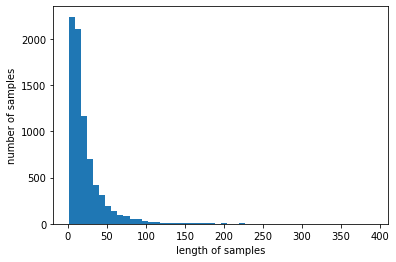

In [114]:
print('리뷰의 최대 길이 :',max(len(l) for l in X_train))
print('리뷰의 평균 길이 :',sum(map(len, X_train))/len(X_train))
plt.hist([len(s) for s in X_train], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [115]:
# 전체 샘플 중 길이가 max_len 이하인 샘플의 비율이 몇 %인지 확인하는 함수
def below_threshold_len(max_len, nested_list):
    cnt = 0
    for s in nested_list:
        if(len(s) <= max_len):
            cnt = cnt + 1
    print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (cnt / len(nested_list))*100))

In [116]:
max_len = 30
below_threshold_len(max_len, X_train)

전체 샘플 중 길이가 30 이하인 샘플의 비율: 78.52626145309071


In [117]:
X_train = pad_sequences(X_train, maxlen = max_len)
X_test = pad_sequences(X_test, maxlen = max_len)

In [118]:
np.save("./save/X_train.npy", X_train)
np.save("./save/X_test.npy", X_test)